# Assignment 6: Apply NB

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    </li>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li></li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
        </ul>
    </li>
    <li>
fine the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using absolute values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print their corresponding feature names
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [61]:
import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [2]:
import pandas as pd
#data = pandas.read_csv('preprocessed_data.csv')
#data.head(5)
data  = pd.read_csv('preprocessed_data.csv',nrows=80000)
# data  = pd.read_csv('preprocessed_data.csv', nrows=50000) # you can take less number of rows like this
#data.head(5)
print(len(data))

80000


In [3]:
data.columns.values

array(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects',
       'project_is_approved', 'clean_categories', 'clean_subcategories',
       'essay', 'price'], dtype=object)

# vectorizing Categorical data

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [4]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)
#y.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [5]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)
print(len(X_train))
print(len(X_test))
print(len(X_cv))


35912
26400
17688


## one hot vector for clean_categories

In [6]:
#one hot vector for clean_categories
vectorizer_clean_cat = CountVectorizer()
vectorizer_clean_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_category_ohe = vectorizer_clean_cat.transform(X_train['clean_categories'].values)
X_cv_clean_category_ohe = vectorizer_clean_cat.transform(X_cv['clean_categories'].values)
X_test_clean_category_ohe = vectorizer_clean_cat.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_category_ohe.shape, y_train.shape)
print(X_cv_clean_category_ohe.shape, y_cv.shape)
print(X_test_clean_category_ohe.shape, y_test.shape)
print(vectorizer_clean_cat.get_feature_names())
print("="*100)

After vectorizations
(35912, 9) (35912,)
(17688, 9) (17688,)
(26400, 9) (26400,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## one hot vector for clean_subcategories

In [7]:
#one hot vector for clean_subcategories
vectorizer_clean_subcat = CountVectorizer()
vectorizer_clean_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategory_ohe = vectorizer_clean_subcat.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategory_ohe.shape, y_train.shape)
print(X_cv_clean_subcategory_ohe.shape, y_cv.shape)
print(X_test_clean_subcategory_ohe.shape, y_test.shape)
print(vectorizer_clean_subcat.get_feature_names())
print("="*100)

After vectorizations
(35912, 30) (35912,)
(17688, 30) (17688,)
(26400, 30) (26400,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


## one hot vector for school_state

In [8]:
#one hot vector for school_state
vectorizer_school_state = CountVectorizer()
vectorizer_school_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_school_state_ohe = vectorizer_school_state.transform(X_train['school_state'].values)
X_cv_school_state_ohe =vectorizer_school_state.transform(X_cv['school_state'].values)
X_test_school_state_ohe = vectorizer_school_state.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state_ohe.shape, y_train.shape)
print(X_cv_school_state_ohe.shape, y_cv.shape)
print(X_test_school_state_ohe.shape, y_test.shape)
print(vectorizer_school_state.get_feature_names())
print("="*100)

After vectorizations
(35912, 51) (35912,)
(17688, 51) (17688,)
(26400, 51) (26400,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## one hot vector for vectorizer_project_grade

In [9]:
#one hot vector for vectorizer_project_grade
vectorizer_project_grade = CountVectorizer()
vectorizer_project_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_project_grade_category_ohe = vectorizer_project_grade.transform(X_train['project_grade_category'].values)
X_cv_project_grade_category_ohe = vectorizer_project_grade.transform(X_cv['project_grade_category'].values)
X_test_project_grade_category_ohe = vectorizer_project_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade_category_ohe.shape, y_train.shape)
print(X_cv_project_grade_category_ohe.shape, y_cv.shape)
print(X_test_project_grade_category_ohe.shape, y_test.shape)
print(vectorizer_project_grade.get_feature_names())
print("="*100)

After vectorizations
(35912, 4) (35912,)
(17688, 4) (17688,)
(26400, 4) (26400,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## one hot vector for teacher_prefixs

In [10]:
#one hot vector for teacher_prefixs
vectorizer_teacher_prefixs = CountVectorizer()
vectorizer_teacher_prefixs.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix_ohe = vectorizer_teacher_prefixs.transform(X_train['teacher_prefix'].values)
X_cv_teacher_prefix_ohe = vectorizer_teacher_prefixs.transform(X_cv['teacher_prefix'].values)
X_test_teacher_prefix_ohe =vectorizer_teacher_prefixs.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
print(vectorizer_teacher_prefixs.get_feature_names())
print("="*100)

After vectorizations
(35912, 5) (35912,)
(17688, 5) (17688,)
(26400, 5) (26400,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


# vectorizing text data

## vectorizing preprocessed_essay (bow)

In [69]:

print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_essay = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer_essay.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)
print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(35912, 8) (35912,)
(17688, 8) (17688,)
(26400, 8) (26400,)
After vectorizations
(35912, 5000) (35912,)
(17688, 5000) (17688,)
(26400, 5000) (26400,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


# vectorizing numerical data

## vectorizing numerical data(price)

In [70]:

from sklearn.preprocessing import Normalizer
normalizer_price = Normalizer()
normalizer_price.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer_price.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer_price.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer_price.transform(X_test['price'].values.reshape(1,-1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 35912) (35912,)
(1, 17688) (17688,)
(1, 26400) (26400,)


## vectorizing numerical data (previously_posted_projects)

In [71]:
from sklearn.preprocessing import Normalizer
normalizer_teacher_projects = Normalizer()
normalizer_teacher_projects.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_teacher_previously_posted_projects_norm = normalizer_teacher_projects.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))



print("After vectorizations")
print(X_train_teacher_previously_posted_projects_norm.shape, y_train.shape)
print(X_cv_teacher_previously_posted_projects_norm.shape, y_cv.shape)
print(X_test_teacher_previously_posted_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(35912, 1) (35912,)
(17688, 1) (17688,)
(26400, 1) (26400,)


## reshaping a numerical data

In [72]:
price_train = (X_train['price'].values.reshape(-1,1))
price_cv = (X_cv['price'].values.reshape(-1,1))
price_test = (X_test['price'].values.reshape(-1,1))


previous_projects_train = (X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
previous_projects_cv = (X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
previous_projects_test = (X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


## Appling NB on different kind of featurization as mentioned in the instructions


## Set 1: categorical, numerical features + preprocessed_eassay (BOW)

In [73]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_clean_category_ohe, X_train_clean_subcategory_ohe,X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe,X_train_essay_bow,price_train,previous_projects_train)).tocsr()
X_cr = hstack((X_cv_clean_category_ohe, X_cv_clean_subcategory_ohe,X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe,X_cv_essay_bow,price_cv,previous_projects_cv)).tocsr()
X_te = hstack((X_test_clean_category_ohe, X_test_clean_subcategory_ohe,X_test_school_state_ohe, X_test_project_grade_category_ohe,X_test_teacher_prefix_ohe,X_test_essay_bow,price_test,previous_projects_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(35912, 5101) (35912,)
(17688, 8) (17688,)
(26400, 5101) (26400,)


## finding hyperparameter using Gridsearchcv

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.5s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.2s
[CV] a

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    6.4s finished
100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 164.20it/s]


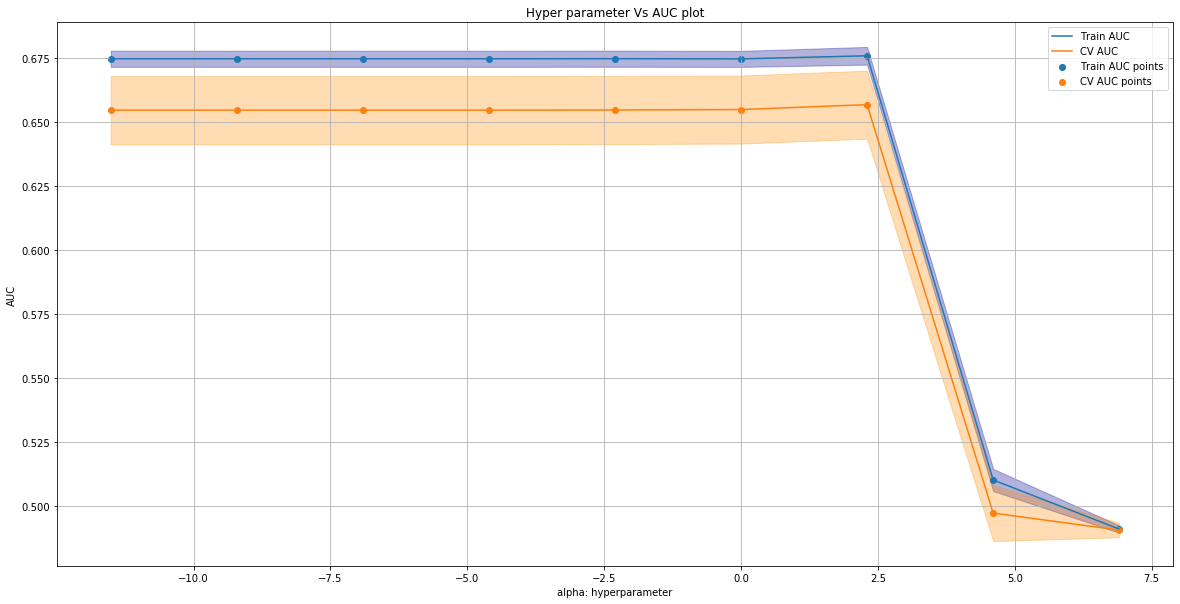

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import math

NB = MultinomialNB(class_prior=[0.5,0.5])#(n_jobs=-1)
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}
clf = RandomizedSearchCV(NB, parameters, cv=3, scoring='roc_auc',return_train_score=True,verbose=2)
clf.fit(X_tr, y_train)

#results = pd.DataFrame.from_dict(clf.cv_results_)
#results = results.sort_values(['param_n_neighbors'])

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
#K =  results['param_n_neighbors']
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
log_alpha = []
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
plt.figure(figsize=(20,10))
plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alpha, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alpha, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head()

In [76]:
best_alpha = clf.best_params_
print(best_alpha)

{'alpha': 10}


In [77]:
best_alpha = 10

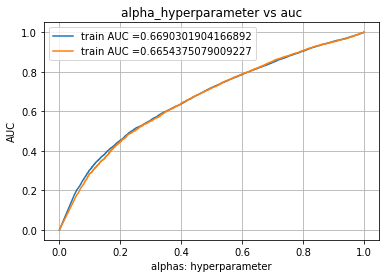

In [78]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=best_alpha, class_prior=[0.5,0.5])
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alphas: hyperparameter")
plt.ylabel("AUC")
plt.title("alpha_hyperparameter vs auc")
plt.grid()
plt.show()

In [79]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [80]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.39177045761691365 for threshold 0.998
Train confusion matrix
[[ 3642  1873]
 [12364 18033]]
Test confusion matrix
[[ 2648  1406]
 [ 9047 13299]]


# vectorizing the preprocessed_essay(TFIDF)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer_tfidf_essay =TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_essay.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer_tfidf_essay.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)



print("NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME")


(35912, 8) (35912,)
(17688, 8) (17688,)
(26400, 8) (26400,)
After vectorizations
(35912, 5000) (35912,)
(17688, 5000) (17688,)
(26400, 5000) (26400,)
NOTE: THE NUMBER OF COLUMNS IN EACH OF THE VECTOR WONT BE SAME


## Set 2: categorical, numerical features + preprocessed_eassay (TFIDF)

In [59]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_clean_category_ohe, X_train_clean_subcategory_ohe,X_train_school_state_ohe, X_train_project_grade_category_ohe, X_train_teacher_prefix_ohe,X_train_essay_tfidf,price_train,previous_projects_train)).tocsr()
X_cr = hstack((X_cv_clean_category_ohe, X_cv_clean_subcategory_ohe,X_cv_school_state_ohe, X_cv_project_grade_category_ohe, X_cv_teacher_prefix_ohe,X_cv_essay_tfidf,price_cv,previous_projects_cv)).tocsr()
X_te = hstack((X_test_clean_category_ohe, X_test_clean_subcategory_ohe,X_test_school_state_ohe, X_test_project_grade_category_ohe,X_test_teacher_prefix_ohe,X_test_essay_tfidf,price_test,previous_projects_test)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(35912, 5101) (35912,)
(17688, 8) (17688,)
(26400, 5101) (26400,)


## finding hyperparameter using gridsearchcv

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ...................................... alpha=1e-05, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.2s
[CV] alpha=0.0001 ....................................................
[CV] ..................................... alpha=0.0001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ...................................... alpha=0.001, total=   0.1s
[CV] a

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    5.3s finished
100%|████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<?, ?it/s]

[CV] ....................................... alpha=1000, total=   0.2s


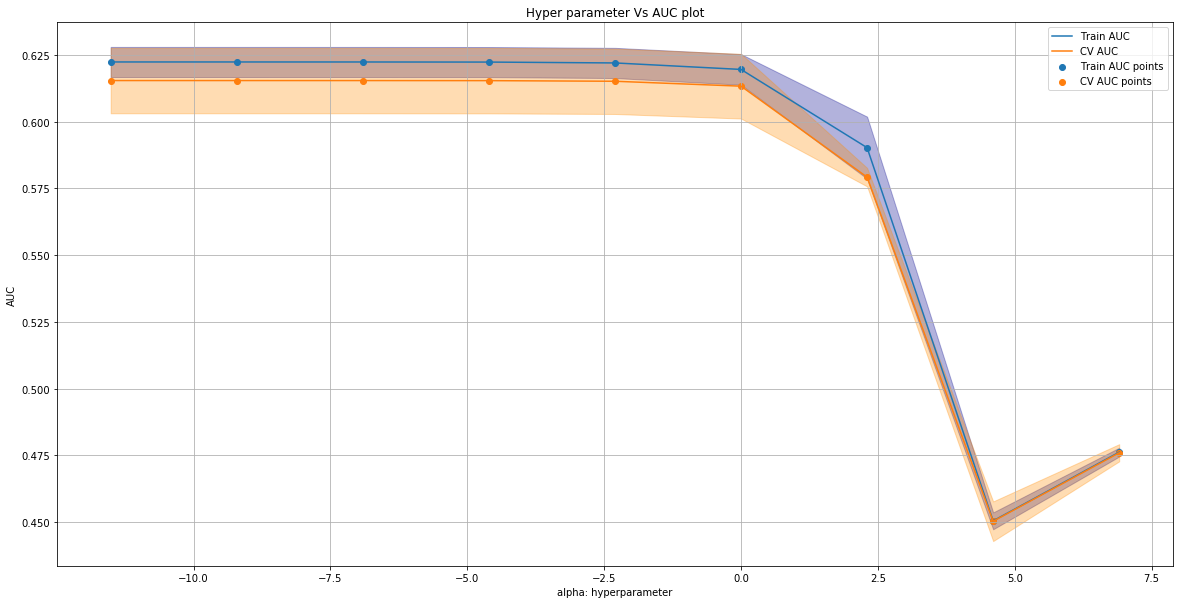

In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
import math

NB = MultinomialNB(class_prior=[0.5,0.5])#(n_jobs=-1)
parameters = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]}
clf = RandomizedSearchCV(NB, parameters, cv=3, scoring='roc_auc',return_train_score=True,verbose=2)
clf.fit(X_tr, y_train)

#results = pd.DataFrame.from_dict(clf.cv_results_)
#results = results.sort_values(['param_n_neighbors'])

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']
#K =  results['param_n_neighbors']
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
log_alpha = []
for a in tqdm(alpha):
    b = math.log(a)
    log_alpha.append(b)
plt.figure(figsize=(20,10))
plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alpha, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alpha, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#results.head()

In [63]:
best_alpha = clf.best_params_
print(best_alpha)

{'alpha': 1e-05}


In [54]:
best_alpha = 5

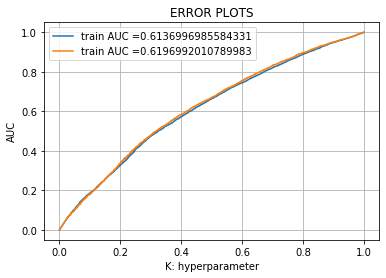

In [55]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=best_alpha, class_prior=[0.5,0.5])
neigh.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(neigh, X_tr)    
y_test_pred = batch_predict(neigh, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [38]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [39]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.344269229460332 for threshold 0.173
Train confusion matrix
[[ 3322  2193]
 [13024 17373]]
Test confusion matrix
[[ 2509  1545]
 [ 9688 12658]]


## selecting top_20 features from set-2

In [93]:
from sklearn.naive_bayes import MultinomialNB
nb_tfidf = MultinomialNB(alpha = 101,class_prior =[0.5,0.5])
nb_tfidf.fit(X_tr,y_train)

MultinomialNB(alpha=101, class_prior=[0.5, 0.5], fit_prior=True)

In [94]:
#referenced from https://stackabuse.com/append-vs-extend-in-python-lists/
tfidf_feature_names = []
for cnt in vectorizer_clean_cat.get_feature_names():
    tfidf_feature_names.append(cnt)
for cnt1 in vectorizer_clean_subcat.get_feature_names():
    tfidf_feature_names.append(cnt)
for cnt2 in vectorizer_school_state.get_feature_names():
    tfidf_feature_names.append(cnt)
for cnt3 in vectorizer_project_grade.get_feature_names():
    tfidf_feature_names.append(cnt)
for cnt4 in vectorizer_teacher_prefixs.get_feature_names():
    tfidf_feature_names.append(cnt)
for cnt in vectorizer_clean_cat.get_feature_names():
    tfidf_feature_names.append(cnt)
tfidf_feature_names.append("price")
tfidf_feature_names.append("teacher_number_of_previously_posted_projects")
for cnt in vectorizer_tfidf_essay.get_feature_names():
    tfidf_feature_names.append(cnt)
    
print(len(tfidf_feature_names))
    
    
    
    

5110


In [95]:
class_1 = nb_tfidf.feature_log_prob_[1,:].argsort()[::-1][:5110]
for i in class_1[:20]:
    print(tfidf_feature_names[i])

young learners
young minds
student
san
multi
learners continue path
class not
texas
no longer
these materials
my kids
later
healthy
maker
my students special
way hopeful
without
read independently
native american
united states


In [96]:
class_0= nb_tfidf.feature_log_prob_[0,:].argsort()[::-1][:5110]
for i in class_0[:20]:
    print(tfidf_feature_names[i])

young learners
student
young minds
san
learners continue path
multi
class not
no longer
later
these materials
texas
healthy
my kids
my students special
maker
way hopeful
native american
without
college career
read independently


## observation:
though the same words present in both the classes but there is a difference in ordering

# <h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [97]:
#http://stackoverflow.com/questions/35160256/how-do-i-output-lists-as-a-table-in-jupyter-notebook
import pandas as pd
data = [["BOW","naive_bayes",10,0.66,0.66],["TFIDF","naive_bayes",5,0.61,0.61]]
pd.DataFrame(data,columns = ["vectorizer","model","hyperparameter","train_auc","test_auc"])

,vectorizer,model,hyperparameter,train_auc,test_auc
0,BOW,naive_bayes,10,0.66,0.66
1,TFIDF,naive_bayes,5,0.61,0.61


## observation
* Naive_bayes gives better test_auc than knn
* And also it is fast as compared to knn

### since in the preprocessed_essay project_title is not given so taken only  essay as a text_data